In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

image = cv2.imread('/content/drive/MyDrive/Impulse_19/Task-4-Image Upscaling/upscaledImg.jpg')[:,:,0]

image = image[0:-1, 0:-1]
image.shape

(255, 255)

**FIRST ORDER EDGE EXTRACTION**

In [3]:
#vertical filter
vertical_filter = [[-1,0,1], [-1,0,1], [-1,0,1]]

#horizontal filter
horizontal_filter = [[-1,-1,-1], [0,0,0], [1,1,1]] 

n,m = image.shape

vedges_img = image.copy()
hedges_img = image.copy()

for row in range(3, n-2):
    for col in range(3, m-2):

      local_pixels = image[row-1:row+2, col-1:col+2]                        #creating a local window for applying the filter iteratively
      vertical_transformed_pixels = vertical_filter*local_pixels          #applying vertical filter
      vertical_score = vertical_transformed_pixels.sum()

      vedges_img[row, col] = vertical_score

for row in range(3, n-2):
    for col in range(3, m-2):

      local_pixels = image[row-1:row+2, col-1:col+2]
      horizontal_transformed_pixels = horizontal_filter*local_pixels      #applying horizontal filter
      horz_score = horizontal_transformed_pixels.sum()

      hedges_img[row, col] = horz_score

**SECOND ORDER EDGE EXTRACTION**

In [4]:
vedges_img2 = vedges_img.copy()
hedges_img2 = hedges_img.copy()

so_hfilter = [[1,0,-2,0,1], [1,0,-2,0,1], [1,0,-2,0,1], [1,0,-2,0,1], [1,0,-2,0,1]]    #initializing second order filters
so_vfilter = [[1,1,1,1,1], [0,0,0,0,0], [-2,-2,-2,-2,-2], [0,0,0,0,0], [1,1,1,1,1]]

for row in range(5, n-4):
    for col in range(5, m-4):

      local_pixels = vedges_img[row-2:row+3, col-2:col+3]                 #creating a local window for applying the filter iteratively
      vertical_transformed_pixels = so_vfilter*local_pixels          #applying vertical filter
      vertical_score = vertical_transformed_pixels.sum()

      vedges_img2[row, col] = vertical_score

for row in range(5, n-4):
    for col in range(5, m-4):

      local_pixels = hedges_img[row-2:row+3, col-2:col+3]
      horizontal_transformed_pixels = so_hfilter*local_pixels      #applying horizontal filter
      horz_score = horizontal_transformed_pixels.sum()

      hedges_img2[row, col] = horz_score

Text(0.5, 1.0, 'second order horizontal edge feature extraction')

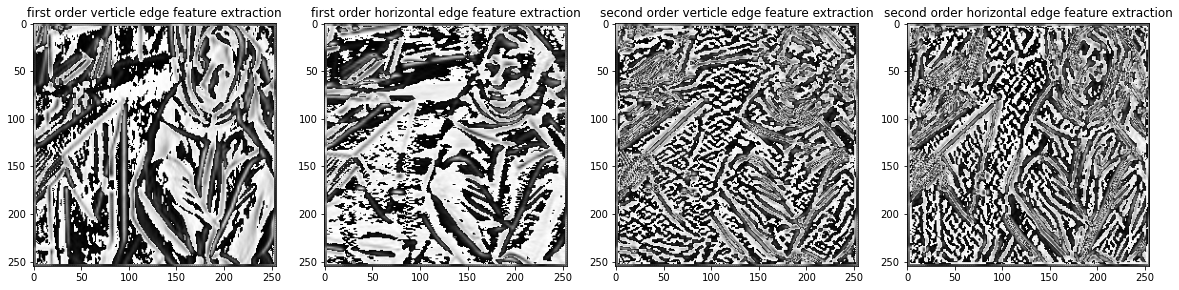

In [5]:
fig, ax = plt.subplots(1, 4, figsize = (20, 20))

ax[0].imshow(vedges_img, cmap = 'gray')
ax[0].set_title('first order verticle edge feature extraction')

ax[1].imshow(hedges_img, cmap = 'gray')
ax[1].set_title('first order horizontal edge feature extraction')

ax[2].imshow(vedges_img2, cmap = 'gray')
ax[2].set_title('second order verticle edge feature extraction')

ax[3].imshow(hedges_img2, cmap = 'gray')
ax[3].set_title('second order horizontal edge feature extraction')


**ORTHOGONAL MATCHING PURSUIT ALGORITHM**

In [6]:
def OMP(A, y, non_zero_terms):
  residue = y
  x = np.zeros(A.shape[1])
  
  for i in range(non_zero_terms):
    dot = np.dot(A.T, residue)            # dot product of all columns of A with y
    dot = dot.reshape((-1,))        

    index = np.argmax(np.abs(dot))        # consider maximum dot product(atom with strongest influence) and ensure that already considered atom in not considered again
    while(x[index] != 0): 
      dot[index] = 0
      index = np.argmax(np.abs(dot))

    x[index] = dot[index]                           # update x
    residue = residue - dot[index] * A[:, index]    # update the residue
  
  return x

In [7]:
import scipy.io 
import numpy as np
from scipy import signal

mat = scipy.io.loadmat('/content/drive/MyDrive/Impulse_19/Task#5/Dictonary.mat')
Dl = mat['Dl']

#normalizing the training dictionary
norm_dl = np.sqrt(np.sum(Dl**2, 1))
Dln = np.divide(Dl, np.transpose(np.tile(norm_dl, (np.size(Dl, 1), 1))))

**Encoding part**

In [8]:
sparse_encodings = []
no_of_non_zero_weights = 50

for i in range(0, 255, 5):
  for j in range(0, 255, 5):

    #extract 5*5 patches
    h1 = hedges_img[i:i+5, j:j+5].reshape((25, ))
    v1 = vedges_img[i:i+5, j:j+5].reshape((25, ))         
    h2 = hedges_img2[i:i+5, j:j+5].reshape((25, ))
    v2 = vedges_img2[i:i+5, j:j+5].reshape((25, ))

    #concatenate to get (100, 1)
    y = np.concatenate((h1, v1, h2, v2))

    #sparse encode using OMP (mainly done to reduce the space consumption of the data, in general)
    sparse = OMP(Dln, y, no_of_non_zero_weights)
    sparse_encodings.append(sparse)

sparse_encodings = np.array(sparse_encodings)
sparse_encodings = sparse_encodings.reshape((51, 51, -1))
sparse_encodings.shape

(51, 51, 512)

In [9]:
# np.save('/content/drive/MyDrive/Impulse_19/Task#5/sparse_representations.npy', sparse_encodings)